First, you'll need to download **Ollama** for your operating system (in this case, Ubuntu). You can find the download link here: [Ollama for Linux](https://ollama.com/download/linux).

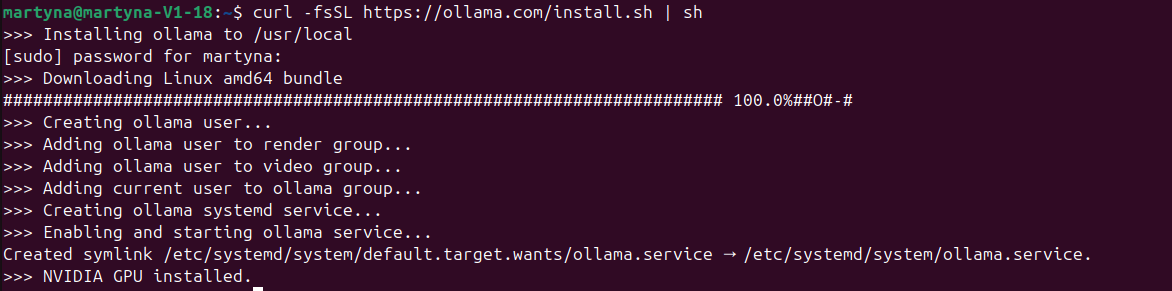

Next, let's pull a model that interests us. For example, I'm using the **mistral-nemo** model from Google, which you can find here: [mistral-nemo:12b](https://ollama.com/library/mistral-nemo:12b).

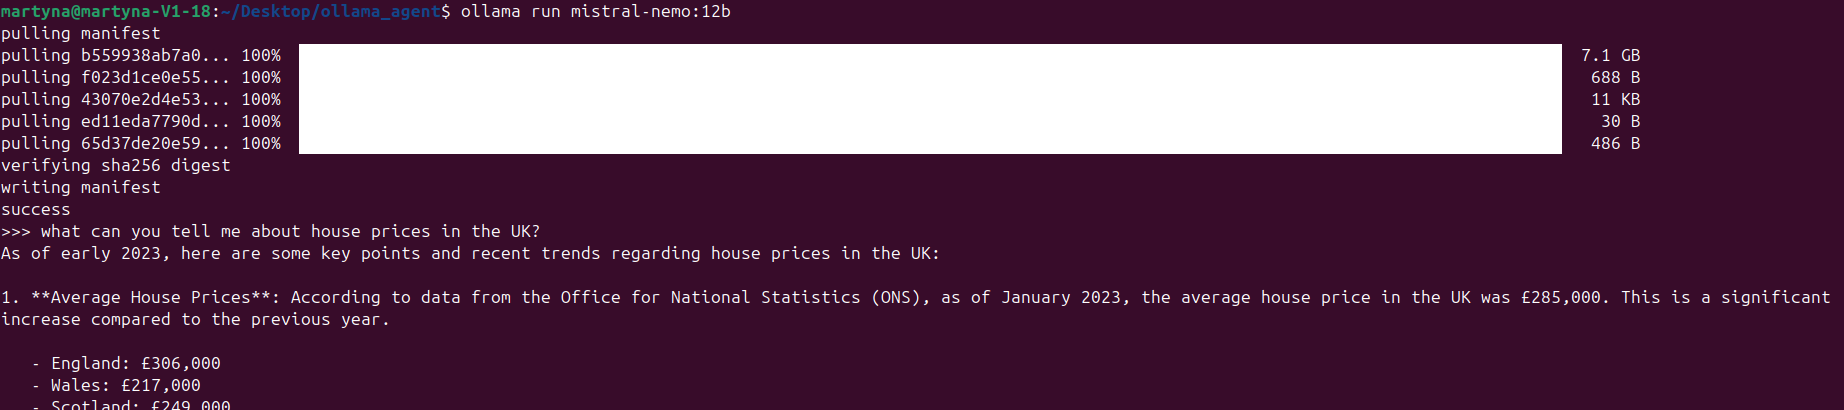

We'll be using Reddit as the main platform for gathering information. To start, you'll need to create an account on Reddit, followed by setting up a search tool.

Special thanks to James Briggs for his insightful tutorial on this topic: [Read the tutorial here](https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c).

For the search functionality, we'll use the `praw` library, a Python Reddit API Wrapper. It simplifies working with Reddit's API compared to using raw `requests`.

In [40]:
import praw 

reddit = praw.Reddit(
    client_id="xLBPF8sJ1DXLgF15gW-nJA",  # personal use script
    client_secret="SESfsRqReWV2M8gxxhwRJwI8VGcFYg",  # secret key (this one is already deleted)
    user_agent="search-tool"  # name of your app
)

We will be extracting submission threads from Reddit, focusing on gathering restaurant recommendations or other relevant details based on our search criteria. For each submission thread, we'll need to capture:

The submission title
The first text or description of the submission
A few of the top-voted comments
To organize this information, we can define a Pydantic class to structure the required data. Here's an example of how the class might look:

In [41]:
from pydantic import BaseModel
from typing import List
from praw.models import Comment
from datetime import datetime, timezone


class Rec(BaseModel):
    title: str
    description: str
    comments: List[str]
    
    def __str__(self):
        """LLM-friendly string representation of the recommendation(s)."""
        return f"Title: {self.title}\nDescription: {self.description}\nComments:\n{'\n'.join(self.comments)}"

Now let's setup the retrieval logic for an example query `house prices in the UK`:

In [51]:
def search(query: str) -> List[Rec]:
    """
    Searches Reddit for posts related to house prices in the Unitred Kingdom.
    Retrieves the top 12 submissions from the current year based on the number of overall votes (upvotes - downvotes).
    """
    current_year = datetime.now(timezone.utc).year
    # Search in a specific subreddit for more relevant results
    results = reddit.subreddit("HousingUK").search(query, time_filter="year", sort="new")
    recs = []
    
    for submission in results:
        # Ensure the post is from the current year
        submission_year = datetime.fromtimestamp(submission.created_utc, tz=timezone.utc).year
        if submission_year == current_year:
            title = submission.title
            description = submission.selftext if submission.selftext else "(Link Post - No Description)"
            comments = []
            for comment in submission.comments.list():
                if isinstance(comment, Comment) and comment.ups >= 20: 
                    author = comment.author.name if comment.author else "unknown"
                    comments.append(f"{author} (upvotes: {comment.ups}): {comment.body}")
            comments = comments[:5]  # Keep the top 5 comments
            
            # Additional filter: Ensure the post mentions something related to house prices
            if any(keyword in title.lower() for keyword in ["apartment prices", "prices", "house", "m2", "flat", "property", "real estate"]) or any(keyword in description.lower() for keyword in ["apartment prices", "prices", "house", "m2", "flat", "property", "real estate"]):
                if len(comments) >= 3:
                    recs.append(Rec(title=title, description=description, comments=comments))

    # Sort by the number of votes (upvotes - downvotes) and return the top 12 results
    recs = sorted(recs, key=lambda x: submission.score, reverse=True)[:12]
    
    return recs


query = "flat prices in Manchester"
search_results = search(query)
search_results

[Rec(title='Age 40 guy, single. Zero savings, Zero Debt. No dependents 50K remote (within UK) job. Best Options?', description="Had a very shitty 30s, undiagnosed chronic health issues and crappy jobs, fell into debt poor credit etc.\n\n2 years ago dug myself out of a shitty situation, got a stable job, paid off all my debts student loans etc and am now age 40, single, no partner, with a net worth of quite literally zero.\n\nSummary\n\n* 40 year old guy\n* Single no partner\n* Currently renting a cramped 1bed flat just outside London.\n* Net pay £3400\n* Disposable income after essentials + food: £2000\n* Excellent credit rating with zero blips in the past 6 years.\n\nFeels like I'm where I expected I would be at age 30, but it is what it is.\n\nWhat are the options for someone who potentially will want to have a family (just one kid) within the next 3-5 years?\n\nIdeally I'd want to be able to buy a decent place i could raise a family in since I'm at the stage where if I don't have a 

In [52]:
print("\n===\n".join([str(rec) for rec in search_results]))

Title: Age 40 guy, single. Zero savings, Zero Debt. No dependents 50K remote (within UK) job. Best Options?
Description: Had a very shitty 30s, undiagnosed chronic health issues and crappy jobs, fell into debt poor credit etc.

2 years ago dug myself out of a shitty situation, got a stable job, paid off all my debts student loans etc and am now age 40, single, no partner, with a net worth of quite literally zero.

Summary

* 40 year old guy
* Single no partner
* Currently renting a cramped 1bed flat just outside London.
* Net pay £3400
* Disposable income after essentials + food: £2000
* Excellent credit rating with zero blips in the past 6 years.

Feels like I'm where I expected I would be at age 30, but it is what it is.

What are the options for someone who potentially will want to have a family (just one kid) within the next 3-5 years?

Ideally I'd want to be able to buy a decent place i could raise a family in since I'm at the stage where if I don't have a family soon it will beco

## Final Answer "Tool"

Alongside our web search tool we will have a final tool called `final_answer`. 

The final answer tool will be called whenever the LLM has finished pulling info from the other two tools and is ready to provide a *final answer* to the user.

In [53]:
def final_answer(answer: str, avg_price: str = "", location: str = "") -> dict:
    """
    Returns a natural language response to the user. The response contains:
    - `answer`: the natural language response to the query about house prices in the UK.
    - `avg_price`: the average price (if found).
    - `location`: the location or region in the United Kingdom where prices were discussed (if found).
    """
    return {
        "answer": answer,
        "avg_price": avg_price,
        "location": location,
    }

## Graph Construction

### Agent State

In [54]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    output: dict[str, Union[str, List[str]]]

### LLM

The LLM acts as our decision maker and generator of our final output. For this we are using Ollama and `gemma2:9b`.

Note: Ollama tool-calling at the moment is not able to call more than one tool at the time. 

In [55]:
system_prompt = """
You are a real estate agent specializing in the housing market of the United Kingdom. A client has asked you for general information about the current state of the UK housing market, including trends and average prices.

Based on the user's query, your task is to provide relevant information about overall housing market conditions in the United Kingdom, including price trends, popular regions, and any notable market insights.

You will achieve this by selecting the appropriate tool from the list provided. When using a tool, specify the tool's name and the necessary arguments in JSON format. The format for each tool call must be as follows:

```json
{
    "name": "<tool_name>",
    "parameters": {
        "<tool_input_key>": "<tool_input_value>"
    }
}
```
Remember, NEVER use the search tool more than 3x as that can lead to a ban from the Reddit API.

After using the search tool you must summarize your findings with the final_answer tool. 
Note, if the user asks a question or says something unrelated to house prices, you must use the final_answer tool directly."""

We use FunctionSchema object with `to_ollama` from `semantic-router` to transform our functions into correctly formatted schemas.

In [56]:
from semantic_router.utils.function_call import FunctionSchema

# create the function calling schema for ollama
search_schema = FunctionSchema(search).to_ollama()

Here's a breakdown:

* `FunctionSchema(search)`: This generates a schema or structured blueprint for the search function. It defines how the function should be called and the parameters it expects.

* `.to_ollama()`: This method converts the schema into a format compatible with the Ollama framework. Ollama uses this schema to allow the LLM to dynamically call the search function during interaction, based on user queries.



In [57]:
search_schema["function"]["parameters"]["properties"]["query"]["description"] = None
search_schema

{'type': 'function',
 'function': {'name': 'search',
  'description': 'Searches Reddit for posts related to house prices in the Unitred Kingdom.\nRetrieves the top 12 submissions from the current year based on the number of overall votes (upvotes - downvotes).',
  'parameters': {'type': 'object',
   'properties': {'query': {'description': None, 'type': 'string'}},
   'required': []}}}

In [58]:
final_answer_schema = FunctionSchema(final_answer).to_ollama()

for key in final_answer_schema["function"]["parameters"]["properties"].keys():
    final_answer_schema["function"]["parameters"]["properties"][key]["description"] = None
final_answer_schema

{'type': 'function',
 'function': {'name': 'final_answer',
  'description': 'Returns a natural language response to the user. The response contains:\n- `answer`: the natural language response to the query about house prices in the UK.\n- `avg_price`: the average price (if found).\n- `location`: the location or region in the United Kingdom where prices were discussed (if found).',
  'parameters': {'type': 'object',
   'properties': {'answer': {'description': None, 'type': 'string'},
    'avg_price': {'description': None, 'type': 'string'},
    'location': {'description': None, 'type': 'string'}},
   'required': ['avg_price', 'location']}}}

Make sure that **Ollama** is running locally and that you have already downloaded the required model (as described at the start of this notebook). 

This ensures that the system is ready for function calling and other interactions with the LLM using the model you've set up.

In [80]:
import ollama

model = "mistral-nemo:12b"

def get_system_tools_prompt(system_prompt: str, tools: list[dict]):
    tools_str = "\n".join([str(tool) for tool in tools])
    return (
        f"{system_prompt}\n\n"
        f"You may use the following tools:\n{tools_str}"
    )

res = ollama.chat(
    model=model,
    messages=[
        {"role": "system", "content": get_system_tools_prompt(
            system_prompt=system_prompt,
            tools=[search_schema, final_answer_schema]
        )},
        # chat history will go here
        {"role": "user", "content": "Hi, what's up?"}
        # scratchpad will go here
    ],
    format="json",
)

In [81]:
res

{'model': 'mistral-nemo:12b',
 'created_at': '2024-10-22T19:23:25.739304886Z',
 'message': {'role': 'assistant',
  'content': '{ "name": "search", "parameters": { "query": "UK house prices" } }'},
 'done_reason': 'stop',
 'done': True,
 'total_duration': 43720447190,
 'load_duration': 15329008,
 'prompt_eval_count': 495,
 'prompt_eval_duration': 39122642000,
 'eval_count': 22,
 'eval_duration': 4456365000}

As we can see, the model used `final_answer` tool which is a desired move in this case. 

In [82]:
import json

json.loads(res["message"]["content"])

{'name': 'search', 'parameters': {'query': 'UK house prices'}}

In [83]:
res = ollama.chat(
    model=model,
    messages=[
        {"role": "system", "content": get_system_tools_prompt(
            system_prompt=system_prompt,
            tools=[search_schema, final_answer_schema]
        )},
        # chat history will go here
        {"role": "user", "content": "Hi, I'd like to know where are the lowest house prices?"}
        # scratchpad will go here
    ],
    format="json",
)
# parse the output
json.loads(res["message"]["content"])

{'name': 'search', 'parameters': {'query': 'lowest house prices UK'}}

As we can see, the model used `search` tool which is also correct.

To keep things a little more organized we can use another pydantic schema to organize the output from our LLM.

In [84]:
class AgentAction(BaseModel):
    tool_name: str
    tool_input: dict
    tool_output: str | None = None

    @classmethod
    def from_ollama(cls, ollama_response: dict):
        try:
            # parse the output
            output = json.loads(ollama_response["message"]["content"])
            return cls(
                tool_name=output["name"],
                tool_input=output["parameters"],
            )
        except Exception as e:
            print(f"Error parsing ollama response:\n{ollama_response}\n")
            raise e

    def __str__(self):
        text = f"Tool: {self.tool_name}\nInput: {self.tool_input}"
        if self.tool_output is not None:
            text += f"\nOutput: {self.tool_output}"
        return text


action = AgentAction.from_ollama(res)
action

AgentAction(tool_name='search', tool_input={'query': 'lowest house prices UK'}, tool_output=None)

In [77]:
def action_to_messages(action: AgentAction) -> list[dict]:
    """Converts an AgentAction into assistant and user messages.

    Args:
        action (AgentAction): The action performed by the agent.

    Returns:
        list[dict]: A list containing the assistant's input message and the user's response message.
    """
    assistant_content = json.dumps({"name": action.tool_name, "parameters": action.tool_input})
    assistant_message = {"role": "assistant", "content": assistant_content}
    user_message = {"role": "user", "content": action.tool_output}
    return [assistant_message, user_message]


def create_scratchpad(intermediate_steps: list[AgentAction]) -> list[dict]:
    """Filters actions with tool output and formats them into assistant and user messages.

    Args:
        intermediate_steps (list[AgentAction]): List of agent actions.

    Returns:
        list[dict]: A list of messages representing the intermediate steps.
    """
    intermediate_steps = [action for action in intermediate_steps if action.tool_output is not None]
    scratch_pad_messages = []
    for action in intermediate_steps:
        scratch_pad_messages.extend(action_to_messages(action))
    return scratch_pad_messages


def call_llm(user_input: str, chat_history: list[dict], intermediate_steps: list[AgentAction]) -> AgentAction:
    """Calls the language model with user input, chat history, and intermediate steps.

    Args:
        user_input (str): The current user input.
        chat_history (list[dict]): The history of the chat session.
        intermediate_steps (list[AgentAction]): Actions the agent has taken so far.

    Returns:
        AgentAction: The next action determined by the language model.
    """
    scratchpad = create_scratchpad(intermediate_steps)
    
    if scratchpad:
        scratchpad += [{
            "role": "user",
            "content": (
                f"Please continue, as a reminder my query was '{user_input}'. "
                "Only answer to the original query, and nothing else — but use the "
                "information I provided to you to do so. Provide as much "
                "information as possible in the `answer` field of the "
                "final_answer tool."
            )
        }]
        tools_used = [action.tool_name for action in intermediate_steps]
        tools = [final_answer_schema] if "search" in tools_used else [search_schema, final_answer_schema]
        scratchpad[-1]["content"] = " You must now use the final_answer tool."
    else:
        tools = [search_schema, final_answer_schema]
    
    messages = [
        {"role": "system", "content": get_system_tools_prompt(system_prompt=system_prompt, tools=tools)},
        *chat_history,
        {"role": "user", "content": user_input},
        *scratchpad,
    ]
    
    res = ollama.chat(model=model, messages=messages, format="json")
    
    return AgentAction.from_ollama(res)

In [85]:
out = call_llm(
    chat_history=[
        {"role": "user", "content": "hi there, how are you?"},
        {"role": "assistant", "content": "I'm good, thanks!"},
        {"role": "user", "content": "I'm currently in Germany"},
        {"role": "assistant", "content": "That's great, would you like any help?"},
    ],
    user_input="yes, I'd like to know the average house prices here",
    intermediate_steps=[]
)
out

AgentAction(tool_name='search', tool_input={'query': 'UK house prices'}, tool_output=None)

In [86]:
results = search(**out.tool_input)
print(results)

[Rec(title='Social housing block opening in our street', description="Just completed a month ago, and heard last night that the block of 40 flats 100m down the road from our 4 bed house has been bought out by a social housing charity. Previously they would have all been privately owned. (Edit: They will be completed next summer.) Several have or are selling up on the street. Feel a bit blindsided but yeah. \n\nWe're relatively new in the UK, but the stories on reddit are... worrying. Hoping to get some positive energy so I can stop worrying about it! Any chance of getting positive stories, please? \n\nThe community feel currently is great around here. I genuinely hope that we can integrate well with what's to come. There are under 20 houses on the street. The apartments I think will end up being very nice by the looks of it. \n\nObligatory 'I'm trying not to be a snob but the stories online scare me 🥲' notice\n\nEngland. \n\nEdit: thanks everyone for the replies. So far I'm sweat-cryin

## Graph Nodes

We have outlined the key logical components of our graph, but in order to execute them in a manner compatible with **LangGraph**, they must work with our `AgentState`. Each component should consume the `AgentState` and return modifications to it, allowing for seamless execution. This will be done through three core functions:

1. **`run_llm`**: This function will be responsible for executing the LLM. It will consume the current `AgentState`, pass the necessary data to the model, and return any updates or new information generated by the model.
  
2. **`router`**: This function manages the routing between the llm and the various tools available. It will determine, based on the `AgentState`, whether the next step should involve running the llm or calling one of the tools.
   
3. **`run_tool`**: This function will execute specific tool functions defined in our graph. It will process the data from the `AgentState`, execute the appropriate tool, and return any modifications or results back to the state.

These functions work together to manage the flow of execution in a modular and reusable way within the LangGraph framework, ensuring that state transitions occur smoothly and that each step is processed as needed.

In [87]:
def run_llm(state: TypedDict) -> dict:
    """Runs the language model with the given state.

    Args:
        state (TypedDict): The current state containing chat history, input, and intermediate steps.

    Returns:
        dict: A dictionary containing the updated intermediate steps.
    """
    print("run_llm")
    chat_history = state["chat_history"]
    out = call_llm(
        user_input=state["input"],
        chat_history=chat_history,
        intermediate_steps=state["intermediate_steps"]
    )
    return {
        "intermediate_steps": [out]
    }


def router(state: TypedDict) -> str:
    """Determines the tool to be used based on the current state.

    Args:
        state (TypedDict): The current state containing intermediate steps.

    Returns:
        str: The name of the tool to be used.
    """
    print("router")
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool_name
    else:
        print("Router invalid format")
        return "final_answer"


tool_str_to_func = {
    "search": search,
    "final_answer": final_answer
}


def run_tool(state: TypedDict) -> dict:
    """Runs the tool specified in the state and returns the result.

    Args:
        state (TypedDict): The current state containing intermediate steps and tool details.

    Returns:
        dict: A dictionary with the output or updated intermediate steps based on the tool run.
    """
    tool_name = state["intermediate_steps"][-1].tool_name
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"run_tool | {tool_name}.invoke(input={tool_args})")
    out = tool_str_to_func[tool_name](**tool_args)
    action_out = AgentAction(
        tool_name=tool_name,
        tool_input=tool_args,
        tool_output=str(out),
    )
    if tool_name == "final_answer":
        return {"output": out}
    else:
        return {"intermediate_steps": [action_out]}


In [89]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)
# Creating a new state graph that will manage the transitions and nodes for the agent's actions, using AgentState as the context.

graph.add_node("llm", run_llm)
# Adding a node called "llm" to the graph, which runs the function `run_llm` (likely handles the language model interaction).

graph.add_node("search", run_tool)
# Adding a node called "search" to the graph, which runs the function `run_tool` (likely handles search operations).

graph.add_node("final_answer", run_tool)
# Adding a node called "final_answer" to the graph, which also runs the function `run_tool` (likely handles generating the final answer).

graph.set_entry_point("llm")  # insert query here
# Setting the entry point of the graph to the "llm" node, meaning that the process starts with calling the language model.

graph.add_conditional_edges(  # - - - >
    source="llm",  # where in graph to start
    path=router,  # function to determine which node is called
)
# Adding conditional edges from the "llm" node. The `router` function decides the next step based on the state.
# This makes the transition dynamic based on the agent's intermediate results.

# create edges from each tool back to the llm
for tool_obj in [search_schema, final_answer_schema]:
    # Looping through the available tool schemas to create connections for each tool's behavior.

    tool_name = tool_obj["function"]["name"]
    # Extracting the tool's function name (e.g., "search" or "final_answer") from the tool schema.

    if tool_name != "final_answer":
        # If the tool is not the "final_answer", then proceed to create an edge back to the "llm" node.

        graph.add_edge(tool_name, "llm")  # ————————>
        # Adding an edge from the current tool (like "search") back to the "llm" node, creating a feedback loop where
        # after running the tool, the agent returns to the language model for further processing.

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)
# Adding a direct edge from the "final_answer" node to the END state, meaning that once the agent provides a final answer,
# the process terminates (completes) at this final state.

runnable = graph.compile()
# Compiling the graph into an executable form. This `runnable` object can now be used to run the state machine
# with all the defined nodes, transitions, and conditional logic.

## Full Flow Summary:

1. **Starting Point:** The process starts at the `"llm"` node, where the agent interacts with a language model (e.g., generating or responding to queries).
2. **Conditional Transitions:** Based on the result of the `"llm"` action, the `router` function determines the next step—either using the `"search"` tool or proceeding to the `"final_answer"` node.
3. **Feedback Loops:** If the `"search"` tool is used, the agent loops back to the `"llm"` node for further processing. This feedback loop allows the agent to iteratively refine its actions until it’s ready to provide a final answer.
4. **Final State:** Once the agent transitions to the `"final_answer"` node, it provides its response, and the process ends at the `END` state, completing the workflow.

This structure enables the agent to dynamically handle a variety of tasks, using tools like search and language models, while allowing for iteration and refinement before delivering the final output.

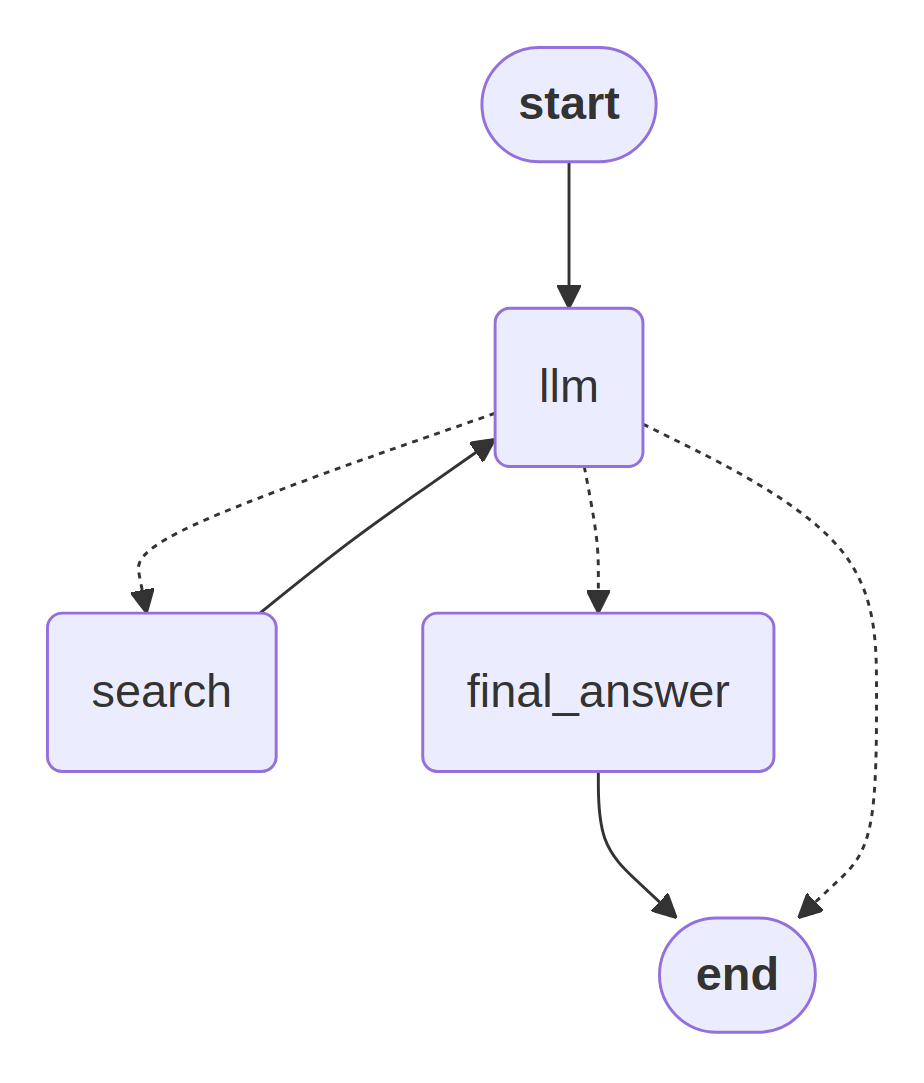

In [90]:
import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

### Let's test the Agent

In [93]:
class AgentAction(BaseModel):
    tool_name: str
    tool_input: dict
    tool_output: str | None = None

    @classmethod
    def from_ollama(cls, ollama_response: dict):
        try:
            # parse the output
            output = json.loads(ollama_response["message"]["content"])
            return cls(
                tool_name=output["name"],
                tool_input=output["parameters"],
            )
        except Exception as e:
            print(f"Error parsing ollama response:\n{ollama_response}\n")
            raise e

    def __str__(self):
        text = f"Tool: {self.tool_name}\nInput: {self.tool_input}"
        if self.tool_output is not None:
            text += f"\nOutput: {self.tool_output}"
        return text


action = AgentAction.from_ollama(res)

out = runnable.invoke({
    "input": "Tell me which areas has the highest house prices",
    "chat_history": [],
})

run_llm
router
run_tool | search.invoke(input={'query': 'highest house prices UK'})
run_llm
router
run_tool | final_answer.invoke(input={'answer': "In the UK housing market, prices have seen significant growth over the past year. According to Rightmove, the average asking price of a home reached £368,509 in April 2023, up by 4.7% annually.\n\nPopular regions include Greater London, where prices averaged around £671,800, and the South East, with an average of £484,500. However, these areas are experiencing significant price corrections due to affordability constraints and changes in commuting patterns following the COVID-19 pandemic.\n\nNotable insights include a growing demand for detached houses and properties in rural areas with good broadband connectivity. Additionally, there's an increasing trend towards hybrid working, driving demand for homes with dedicated office space.", 'avg_price': '£368,509', 'location': 'UK'})


In [96]:
out["output"]['answer']

"In the UK housing market, prices have seen significant growth over the past year. According to Rightmove, the average asking price of a home reached £368,509 in April 2023, up by 4.7% annually.\n\nPopular regions include Greater London, where prices averaged around £671,800, and the South East, with an average of £484,500. However, these areas are experiencing significant price corrections due to affordability constraints and changes in commuting patterns following the COVID-19 pandemic.\n\nNotable insights include a growing demand for detached houses and properties in rural areas with good broadband connectivity. Additionally, there's an increasing trend towards hybrid working, driving demand for homes with dedicated office space."

---